# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Config

In [11]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load data

In [12]:
df = pd.read_csv("mod_data.csv", index_col="date", parse_dates=True, dtype=np.float32)
df

,close,volume,volume_norm,log_close,log_fit,log_diff,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-1.424,-0.878,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-1.418,-0.884,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-1.412,-0.890,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-1.406,-0.896,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-1.400,-0.902,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...,...,...
2021-11-21,"58,714.301","40,980.000",-0.523,10.980,9.416,1.564,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,308.801","76,450.000",-0.392,10.939,9.416,1.523,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,573.199","72,480.000",-0.406,10.961,9.416,1.545,-0.993,-0.116,-0.616,0.787


In [13]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 close          float32
 volume         float32
 volume_norm    float32
 log_close      float32
 log_fit        float32
 log_diff       float32
 month_sin      float32
 month_cos      float32
 year_sin       float32
 year_cos       float32
 dtype: object)

In [14]:
features = ["volume_norm", "log_diff", "month_sin", "month_cos", "year_sin", "year_cos"]

# Load Model

In [15]:
model = tf.keras.models.load_model("saved_model/v1.h5")

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 42)                8232      
                                                                 
 dense_3 (Dense)             (None, 7)                 301       
                                                                 
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [16]:
def get_forecast(df, features, model):
    # vals
    x = df[features].iloc[-21:].values.reshape((1, 21, 6))
    y = model.predict(x)[0]
    
    #dates
    dates_x = pd.date_range(df.index[-21], periods=28, freq="D")
    dates_y = dates_x[-7:]
    dates_x = dates_x[:-7]

    # convert X
    x = np.exp(df["log_diff"].iloc[-21:].values + df["log_fit"].iloc[-21:].values)

    # convert y
    y = np.exp(y + df["log_fit"].iloc[-1])

    #plot
    plt.plot(dates_x, x, label="history", color="blue")
    plt.plot(dates_y, y, label="forecast", color="red")
    plt.plot([dates_x[-1], dates_y[0]], [x[-1], y[0]], color="red", linestyle="--")
    plt.legend()
    plt.plot()

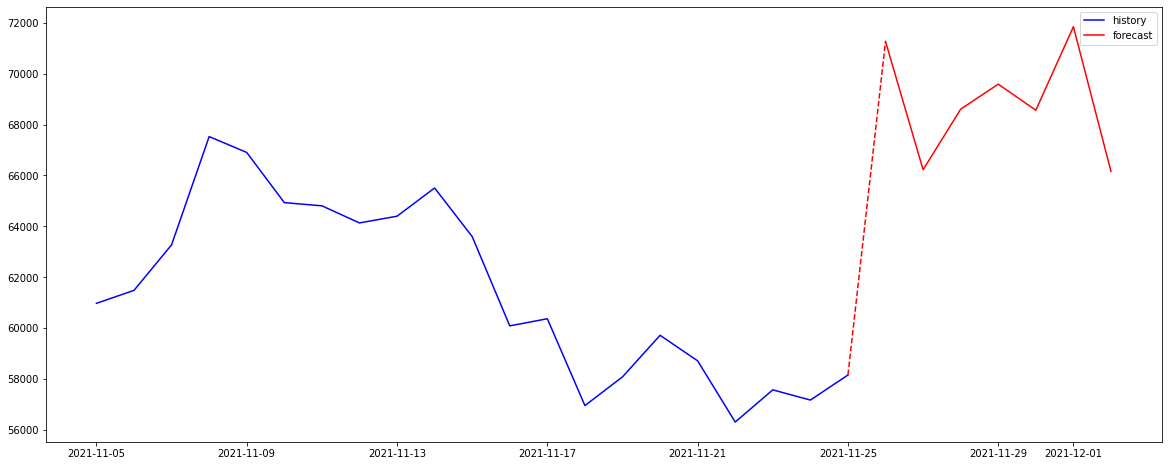

In [17]:
get_forecast(df, features, model)